In [1]:
import timeit
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

Importing plotly failed. Interactive plots will not work.


In [2]:
import pymc_experimental as pmx

# Class implementation

In [14]:
NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000

class MyProphet():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 yearly_prior_scale=10.0,
                 weekly_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                 delta_mean=0,
                 beta_yearly_mean=0,
                 beta_weekly_mean=0,
                 old_trace=None,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.yearly_prior_scale = yearly_prior_scale
        self.weekly_prior_scale = weekly_prior_scale
        self.mcmc_samples = mcmc_samples
        
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma
        self.delta_mean = delta_mean
        self.beta_yearly_mean = beta_yearly_mean
        self.beta_weekly_mean = beta_weekly_mean

        self.old_trace = old_trace
        
        self.model = None
        self.init_vals = None
        self.trend_params = None
        self.yearly_seasonality_params = None
        self.weekly_seasonality_params = None
        self.map_approx = None
        self.trace = None
        self.posterior = None
        
        self.data = None
        self.y_min = None
        self.y_max = None
        self.ds_min = None
        self.ds_max = None

    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        
    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        k = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        m = self.data["y"].iloc[i0] - k * self.data["t"].iloc[i0]
        delta = np.zeros(self.n_changepoints)
        self.init_vals = {"k": k, "m": m, "delta": delta, "beta_yearly": 0.0, "beta_weekly": 0.0, "sigma": 1.0}

    def _add_trend(self, priors):
        t = np.array(self.data["t"])
        hist_size = int(np.floor(self.data.shape[0] * self.changepoint_range))
        cp_indexes = np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        s = np.array(self.data.iloc[cp_indexes]["t"].tail(-1))
    
        # * 1 casts the boolean to integers
        A = (t[:, None] > s) * 1
    
        with self.model:
            # initial growth
            if self.old_trace is None:
                k = pm.Normal("k", self.k_mean , self.k_sd, initval=self.init_vals["k"])
            else:
                k = priors["k"]

            changepoints_prior_scale = self.changepoints_prior_scale
            if self.changepoints_prior_scale is None:
                if self.old_trace is None:
                    changepoints_prior_scale = pm.Exponential("tau", 1.5)
                else:
                    changepoints_prior_scale = priors["tau"]
        
            # rate of change
            if self.old_trace is None:
                delta = pm.Laplace("delta", self.delta_mean, changepoints_prior_scale, shape=self.n_changepoints, initval=self.init_vals["delta"])
            else:
                delta = priors["delta"]
            # offset
            if self.old_trace is None:
                m = pm.Normal("m", self.m_mean, self.m_sd, initval=self.init_vals["m"])
            else:
                m = priors["m"]
            gamma = -s * delta
            trend = pm.Deterministic("trend", (k + pyt.tensor.dot(A, delta)) * t + (m + pyt.tensor.dot(A, gamma)))

        return trend, A, s

    def _fourier_series(self, data, period=365.25, series_order=10,):
        # convert to days since epoch
        t = data["ds"].to_numpy(dtype=np.int64) // NANOSECONDS_TO_SECONDS / (3600 * 24.)
    
        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * series_order))
        for i in range(series_order):
            c = x_T * (i + 1) / period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)
            
        return fourier_components

    def _get_seasonality_n_x(self, data, period):
        if period == "yearly":
            n = 10
            p = 365.25
        else:  # weekly
            n = 3
            p = 7
            
        return n, self._fourier_series(data, p, n)

    def _add_seasonality(self, period, mean, priors):
        n, x = self._get_seasonality_n_x(self.data, period)
        scale = self.yearly_prior_scale if period == "yearly" else self.weekly_prior_scale
    
        with self.model:
            if self.old_trace is None:
                beta = pm.Normal(
                    f"beta_{period}", 
                    mu=mean, 
                    sigma=scale, 
                    shape=2 * n, 
                    initval=np.array([mean] * 2 * n) if type(mean) is int else mean
                )
            else:
                beta = priors[f"beta_{period}"]
            
        return x, beta

    def fit(self, data):
        self.data = data.reset_index(drop=True)
        self._process_data()
        self._model_init()

        self.model = pm.Model()
        with self.model:
            priors = None
            if self.old_trace is not None:
                priors = pmx.utils.prior.prior_from_idata(
                    self.old_trace, 
                    var_names=["k", "m", "delta", "beta_yearly", "beta_weekly"] + (["tau"] if self.changepoints_prior_scale is None else [])
                )
    
            trend, A, s = self._add_trend(priors)
            x_yearly, beta_yearly = self._add_seasonality("yearly", self.beta_yearly_mean, priors)
            x_weekly, beta_weekly = self._add_seasonality("weekly", self.beta_weekly_mean, priors)
            trend += pyt.tensor.dot(x_yearly, beta_yearly) + pyt.tensor.dot(x_weekly, beta_weekly)
            # sigma = pm.HalfCauchy("sigma", 0.5, initval=1)
            sigma = pm.HalfNormal("sigma", self.sigma, initval=self.init_vals["sigma"])
            obs = pm.Normal("obs", mu=trend, sigma=sigma, observed=self.data["y"])
         
            
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=False, maxeval=1e4)
                
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=4, cores=4)
                # self.posterior = pm.sample_posterior_predictive(trace=self.trace)

        self.trend_params = (trend, A, s)
        self.yearly_seasonality_params = (x_yearly, beta_yearly)
        self.weekly_seasonality_params = (x_weekly, beta_weekly)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _plot_predictions(self, future, y_true=None):
        date = future["ds"].dt.to_pydatetime()
        plt.figure(figsize=(16, 3*6))
        b = 411
        plt.subplot(b)
        plt.title("Predictions")
        plt.plot(date, future["yhat"], lw=0.5)
        plt.scatter(date[:len(self.data)], self.data["y"] * self.y_max, s=0.5, color="black")

        if y_true is not None:
            plt.scatter(date[len(self.data):], y_true, s=0.5, color="green")

        plt.subplot(b + 1)
        plt.title("Trend component")
        plt.plot(date, future["trend"], lw=0.5)

        plt.subplot(b + 2)
        plt.title("Yearly component")
        plt.plot(date, future["yearly"], lw=0.5)

        plt.subplot(b + 3)
        plt.title("Weekly component")
        plt.plot(date, future["weekly"], lw=0.5)

    def _make_future_df(self, days):
        future = pd.DataFrame({
            "ds": pd.DatetimeIndex(pd.concat((
                self.data["ds"], 
                pd.date_range(self.ds_max, self.ds_max + pd.Timedelta(days, "D"), inclusive="right").to_series(),
            )))
        })
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future
    
    def _predict_map(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        future = self._make_future_df(days)
        new_A = (np.array(future["t"])[:, None] > s) * 1
        
        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        future["yearly"] = self._det_seasonality_posterior(self.map_approx["beta_yearly"], x_yearly) * self.y_max
        future["weekly"] = self._det_seasonality_posterior(self.map_approx["beta_weekly"], x_weekly) * self.y_max        
        future["trend"] = np.array((
            (self.map_approx["k"] + np.dot(new_A, self.map_approx["delta"])) * future["t"] + 
            (self.map_approx["m"] + np.dot(new_A, (-s * self.map_approx["delta"])))
        ) * self.y_max)

        future["yhat"] = future["trend"] + future["yearly"] + future["weekly"]

        if plot:
            self._plot_predictions(future, y_true)
            
        return future

    def _predict_mcmc(self, days, y_true=None, plot=False):
        _, _, s = self.trend_params
        future = self._make_future_df(days)
        new_A = (np.array(future["t"])[:, None] > s) * 1

        _, x_yearly = self._get_seasonality_n_x(future, "yearly")
        _, x_weekly = self._get_seasonality_n_x(future, "weekly")
        
        beta_yearly = self.trace["posterior"]["beta_yearly"].to_numpy().mean(0)
        beta_weekly = self.trace["posterior"]["beta_weekly"].to_numpy().mean(0)
        delta = self.trace["posterior"]["delta"].to_numpy().mean(0)
        k = self.trace["posterior"]["k"].to_numpy().mean(0)
        m = self.trace["posterior"]["m"].to_numpy().mean(0)
        
        trend_forecast = ((k + np.dot(new_A, delta.T)).T * future["t"].to_numpy() + (m + np.dot(new_A, (-s * delta).T)).T) * self.y_max
        yearly_posterior = self._det_seasonality_posterior(beta_yearly, x_yearly) * self.y_max
        weekly_posterior = self._det_seasonality_posterior(beta_weekly, x_weekly) * self.y_max
        
        future["yhat"] = (trend_forecast + yearly_posterior.T + weekly_posterior.T).mean(0)
        future["trend"] = trend_forecast.mean(0)
        future["yearly"] = yearly_posterior.T.mean(0)
        future["weekly"] = weekly_posterior.T.mean(0)

        if plot:
            self._plot_predictions(future, y_true)
        
        return future

class MyProphetWrapper():
    def __init__(self,
                 n_changepoints=25,
                 changepoints_prior_scale=0.05,
                 changepoint_range=0.8,
                 yearly_prior_scale=10.0,
                 weekly_prior_scale=10.0,
                 mcmc_samples=0,
                 k_mean=0,
                 k_sd=5,
                 m_mean=0,
                 m_sd=5,
                 sigma=0.5,
                 delta_mean=0,
                 beta_yearly_mean=0,
                 beta_weekly_mean=0,
                ):
        self.n_changepoints = n_changepoints
        self.changepoints_prior_scale = changepoints_prior_scale
        self.changepoint_range = changepoint_range
        self.yearly_prior_scale = yearly_prior_scale
        self.weekly_prior_scale = weekly_prior_scale
        self.mcmc_samples = mcmc_samples
        
        self.k_mean = k_mean
        self.k_sd = k_sd
        self.m_mean = m_mean
        self.m_sd = m_sd
        self.sigma = sigma
        self.delta_mean = delta_mean
        self.beta_yearly_mean = beta_yearly_mean
        self.beta_weekly_mean = beta_weekly_mean

    def _calculate_metrics(self, ys, yhats, horizon):
        metrics = {"horizon": [], "mse": [], "rmse": [], "mae": [], "mape": []}

        for k in tqdm(range(horizon)):
            y_true = [y[y["day_idx"] == k]["y"].values[0] for y in ys if k in y["day_idx"].values]
            y_pred = [y[y["day_idx"] == k]["y"].values[0] for y in yhats if k in y["day_idx"].values]
            
            metrics["horizon"].append(k + 1)
            metrics["mse"].append(mean_squared_error(y_true, y_pred))
            metrics["rmse"].append(root_mean_squared_error(y_true, y_pred))
            metrics["mae"].append(mean_absolute_error(y_true, y_pred))
            metrics["mape"].append(mean_absolute_percentage_error(y_true, y_pred))

        return pd.DataFrame.from_dict(metrics)

    def test_prophet(self, df, window=730, horizon=365, extend_window=False, limit=None):
        yhats = []
        ys = []

        l = len(df) - window - horizon - 1
        if limit is not None:
            l = limit
        
        for start in tqdm(range(l)):
            model = Prophet(
                n_changepoints=self.n_changepoints,
                changepoint_prior_scale=self.changepoints_prior_scale,
                changepoint_range=self.changepoint_range,
                seasonality_prior_scale=self.yearly_prior_scale,
            )

            if extend_window:
                model.fit(df[:start + window])
            else:
                model.fit(df[start:start + window])

            future = model.make_future_dataframe(periods=horizon, include_history=False)
            
            y = df[start + window:start + window + horizon].copy()
            y["ds"] = pd.to_datetime(y["ds"])
            yhat = model.predict(future)
        
            y = y[y["ds"].isin(yhat["ds"])]
            yhat = yhat[yhat["ds"].isin(y["ds"])]
        
            y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
            ys.append(y)
        
            yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
            yhat["y"] = yhat["yhat"]
            yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
            yhats.append(yhat)
        

        return self._calculate_metrics(ys, yhats, horizon)

    def test_my_prophet(self, df, update_priors_days=1, window=730, horizon=365, extend_window=False, limit=None):
        yhats = []
        ys = []
        
        k_mean = self.k_mean
        k_sd = self.k_sd
        m_mean = self.m_mean
        m_sd = self.m_sd
        sigma = self.sigma
        delta_mean = self.delta_mean
        beta_yearly_mean = self.beta_yearly_mean
        beta_weekly_mean = self.beta_weekly_mean
        changepoints_prior_scale = self.changepoints_prior_scale
        yearly_prior_scale = self.yearly_prior_scale
        weekly_prior_scale = self.weekly_prior_scale
        
        old_trace = None

        l = len(df) - window - horizon - 1
        if limit is not None:
            l = limit
        
        for start in tqdm(range(l)):
            if update_priors_days > 0 and start % update_priors_days == 0:
                mcmc_samples = self.mcmc_samples
            else:
                mcmc_samples = 0
        
            model = MyProphet(
                n_changepoints=self.n_changepoints,
                changepoints_prior_scale=changepoints_prior_scale,
                changepoint_range=self.changepoint_range,
                yearly_prior_scale=yearly_prior_scale,
                weekly_prior_scale=weekly_prior_scale,
                mcmc_samples=mcmc_samples,
                k_mean=k_mean,
                k_sd=k_sd,
                m_mean=m_mean,
                m_sd=m_sd,
                sigma=sigma,
                delta_mean=delta_mean,
                beta_yearly_mean=beta_yearly_mean,
                beta_weekly_mean=beta_weekly_mean,
                old_trace=old_trace
            )

            if extend_window:
                model.fit(df[:start + window])
            else:
                model.fit(df[start:start + window])
            
            y = df[start + window:start + window + horizon].copy()
            y["ds"] = pd.to_datetime(y["ds"])
            yhat = model._predict_map(horizon) if mcmc_samples == 0 else model._predict_mcmc(horizon)
        
            y = y[y["ds"].isin(yhat["ds"])]
            yhat = yhat[yhat["ds"].isin(y["ds"])]
        
            y["day_idx"] = (y["ds"] - y["ds"].min()).dt.days
            ys.append(y)
        
            yhat["day_idx"] = (yhat["ds"] - yhat["ds"].min()).dt.days
            yhat["y"] = yhat["yhat"]
            yhat.drop(yhat.columns.difference(["ds", "y", "day_idx"]), axis=1, inplace=True)
            yhats.append(yhat)
        
            if update_priors_days > 0 and start % update_priors_days == 0:
                if self.mcmc_samples == 0:
                    k_mean = model.map_approx["k"]
                    m_mean = model.map_approx["m"]
                    delta = model.map_approx["delta"]
                    beta_yearly_mean = model.map_approx["beta_yearly"]
                    beta_weekly_mean = model.map_approx["beta_weekly"]
                else:
                    # old_trace = model.trace
                    summary = az.summary(model.trace, var_names=["k", "m", "sigma", "delta", "beta_yearly", "beta_weekly"])
                    # delta_idx = [elem for elem in summary.index if elem.startswith("delta")]
                    beta_yearly_idx = [elem for elem in summary.index if elem.startswith("beta_yearly")]
                    beta_weekly_idx = [elem for elem in summary.index if elem.startswith("beta_weekly")]
                    
                    # k_mean = summary["mean"]["k"]
                    # k_sd = summary["sd"]["k"]
                    # m_mean = summary["mean"]["m"]
                    # m_sd = summary["sd"]["m"]
                    # delta_mean = summary["mean"][delta_idx]
                    # changepoint_prior_scale = summary["sd"][delta_idx]
                    beta_yearly_mean = summary["mean"][beta_yearly_idx]
                    beta_weekly_mean = summary["mean"][beta_weekly_idx]
                    # yearly_prior_scale = summary["sd"][beta_yearly_idx]
                    # weekly_prior_scale = summary["sd"][beta_weekly_idx]
                
        return self._calculate_metrics(ys, yhats, horizon)

# Fetch data

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv")
df

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572
...,...,...
2900,2016-01-16,7.817223
2901,2016-01-17,9.273878
2902,2016-01-18,10.333775
2903,2016-01-19,9.125871


# Test MCMC sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 140 seconds.
/tmp/ipykernel_1009/2987390984.py:187: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


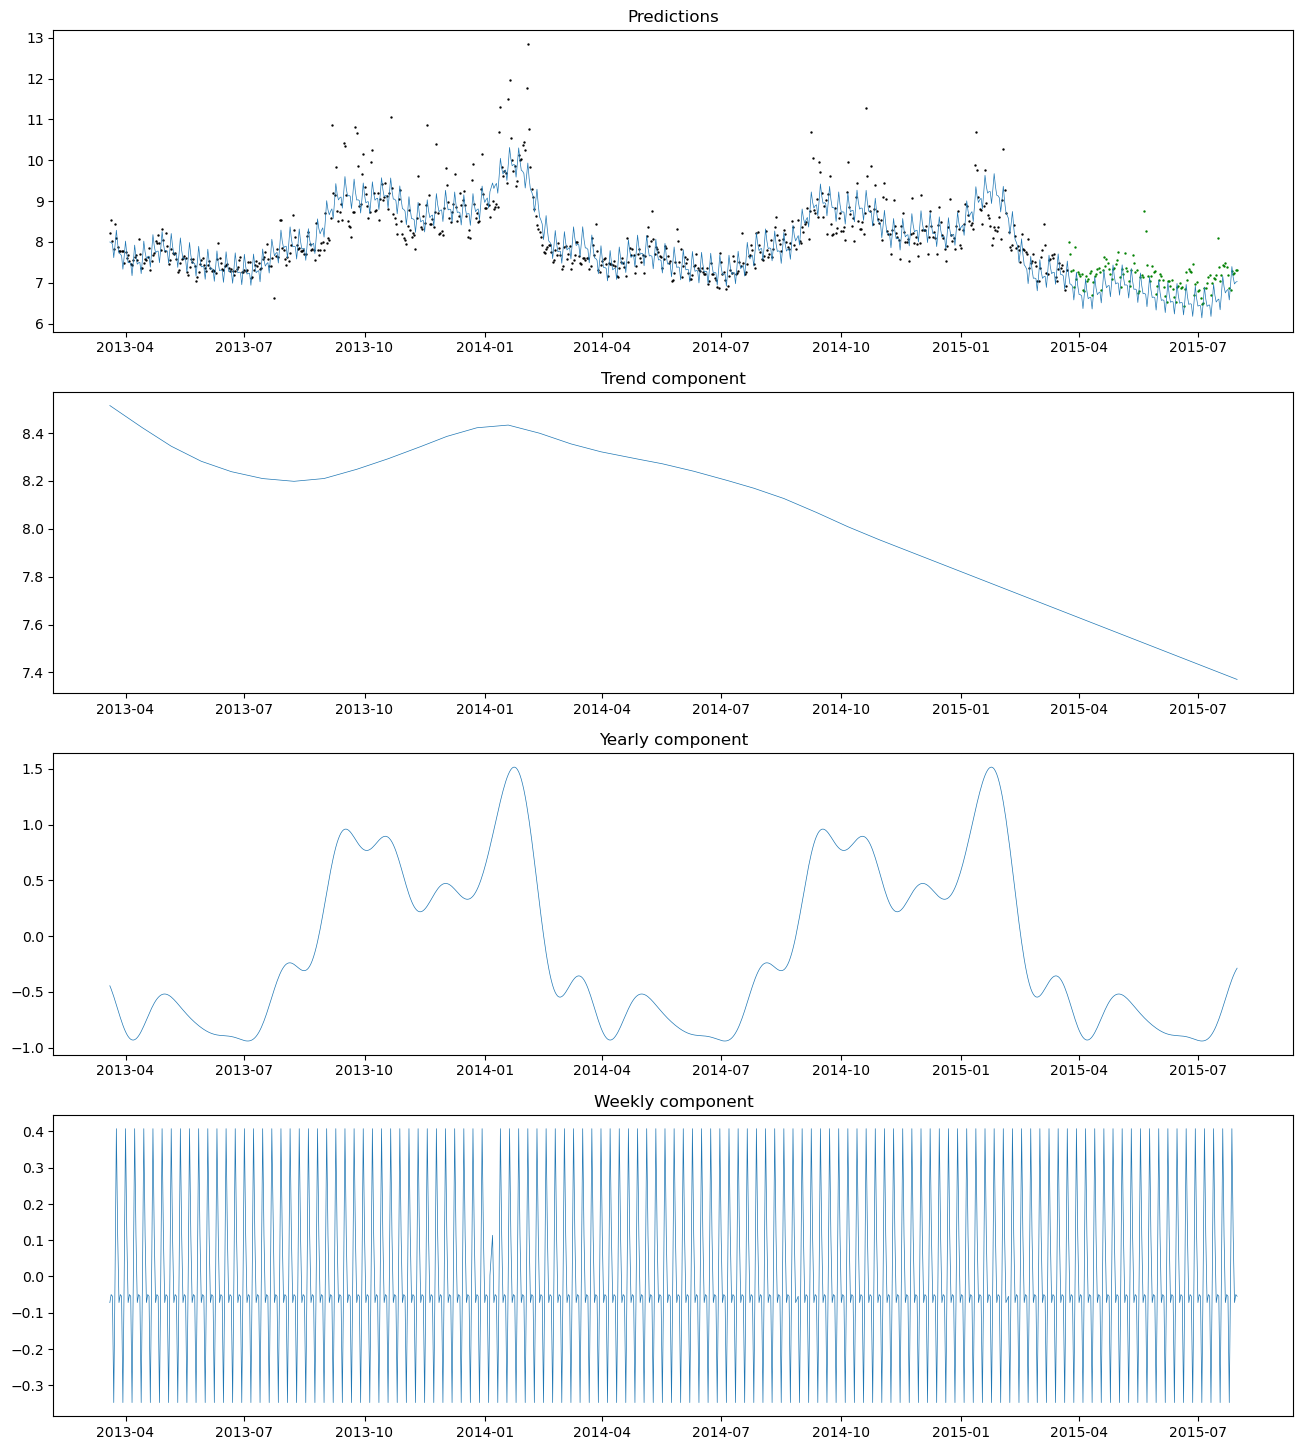

In [90]:
window = 730
horizon = 130
start = randint(0, len(df) - window - horizon - 1)

my_model = MyProphet(mcmc_samples=1000)
my_model.fit(df[start:start + window])
preds = my_model._predict_mcmc(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


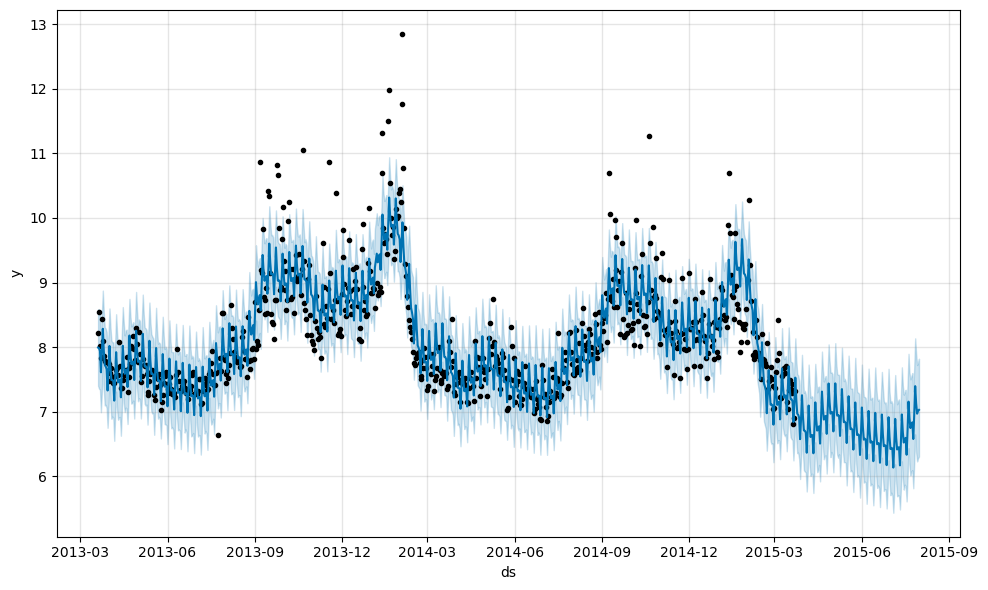

In [91]:
model = Prophet(mcmc_samples=1000)
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

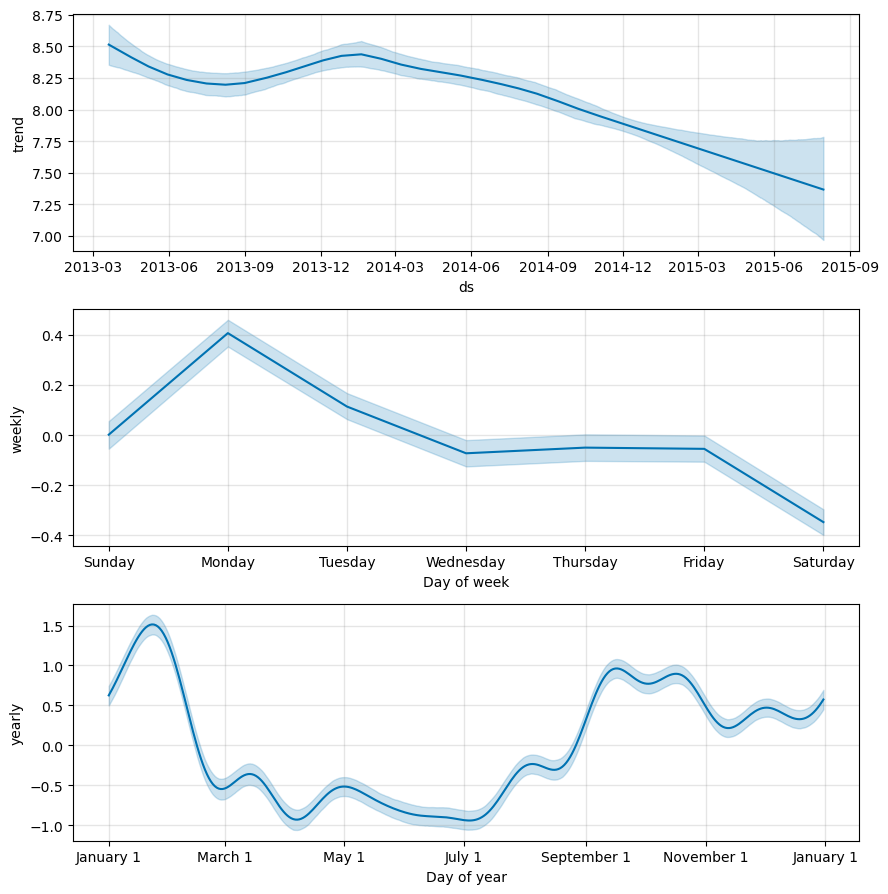

In [92]:
fig = model.plot_components(forecast)

In [93]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], preds["yhat"][window:])

0.05869229317994342

In [94]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], forecast["yhat"][window:])

0.058767262419385145

In [95]:
mean_absolute_percentage_error(forecast["yhat"][window:], preds["yhat"][window:])

0.00024146026461975561

# Test MAP

/tmp/ipykernel_1009/2987390984.py:187: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


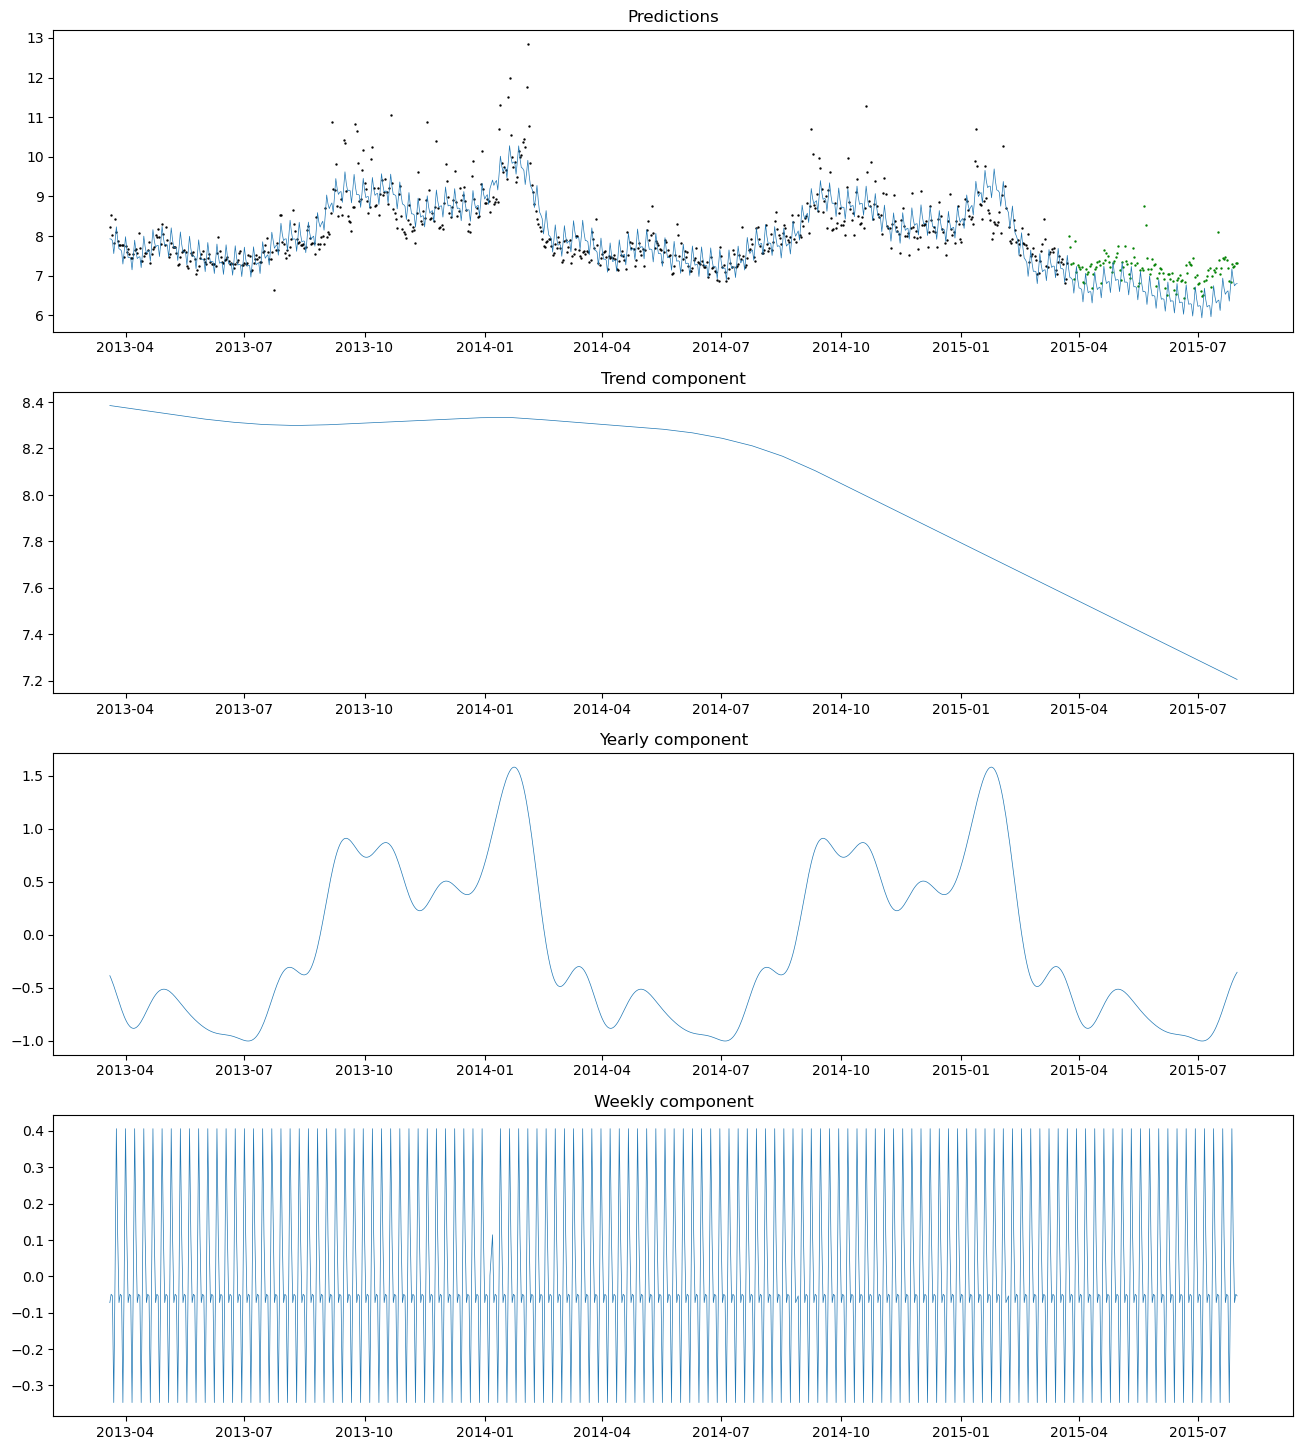

In [96]:
my_model = MyProphet()
my_model.fit(df[start:start + window])
preds = my_model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


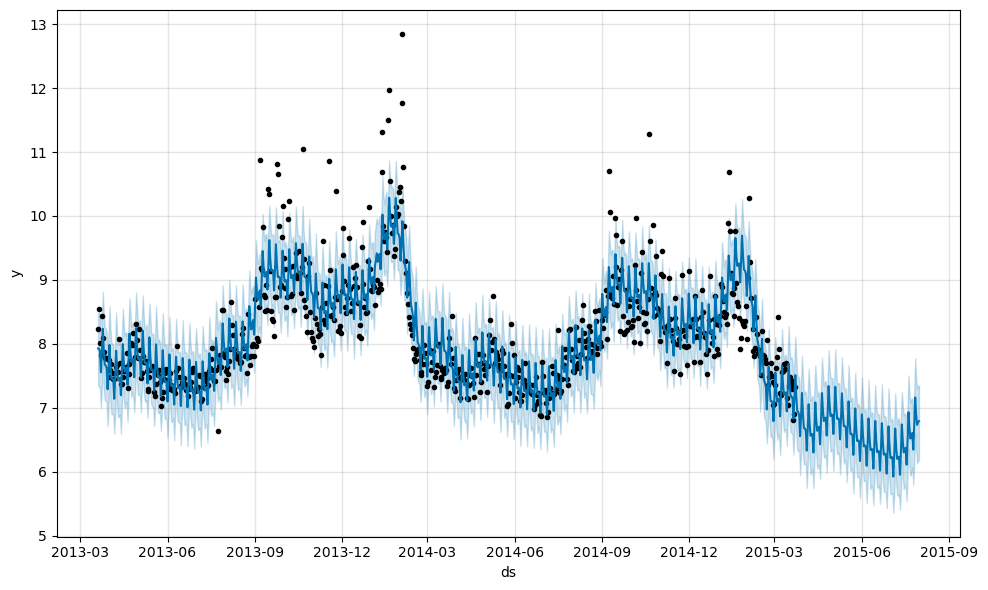

In [97]:
model = Prophet()
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

In [99]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], preds["yhat"][window:])

0.07593385693011001

In [100]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], forecast["yhat"][window:])

0.0767416212790208

In [101]:
mean_absolute_percentage_error(forecast["yhat"][window:], preds["yhat"][window:])

0.0009034794396953102

# MCMC on full dataset

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 907 seconds.
/tmp/ipykernel_1009/2987390984.py:187: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


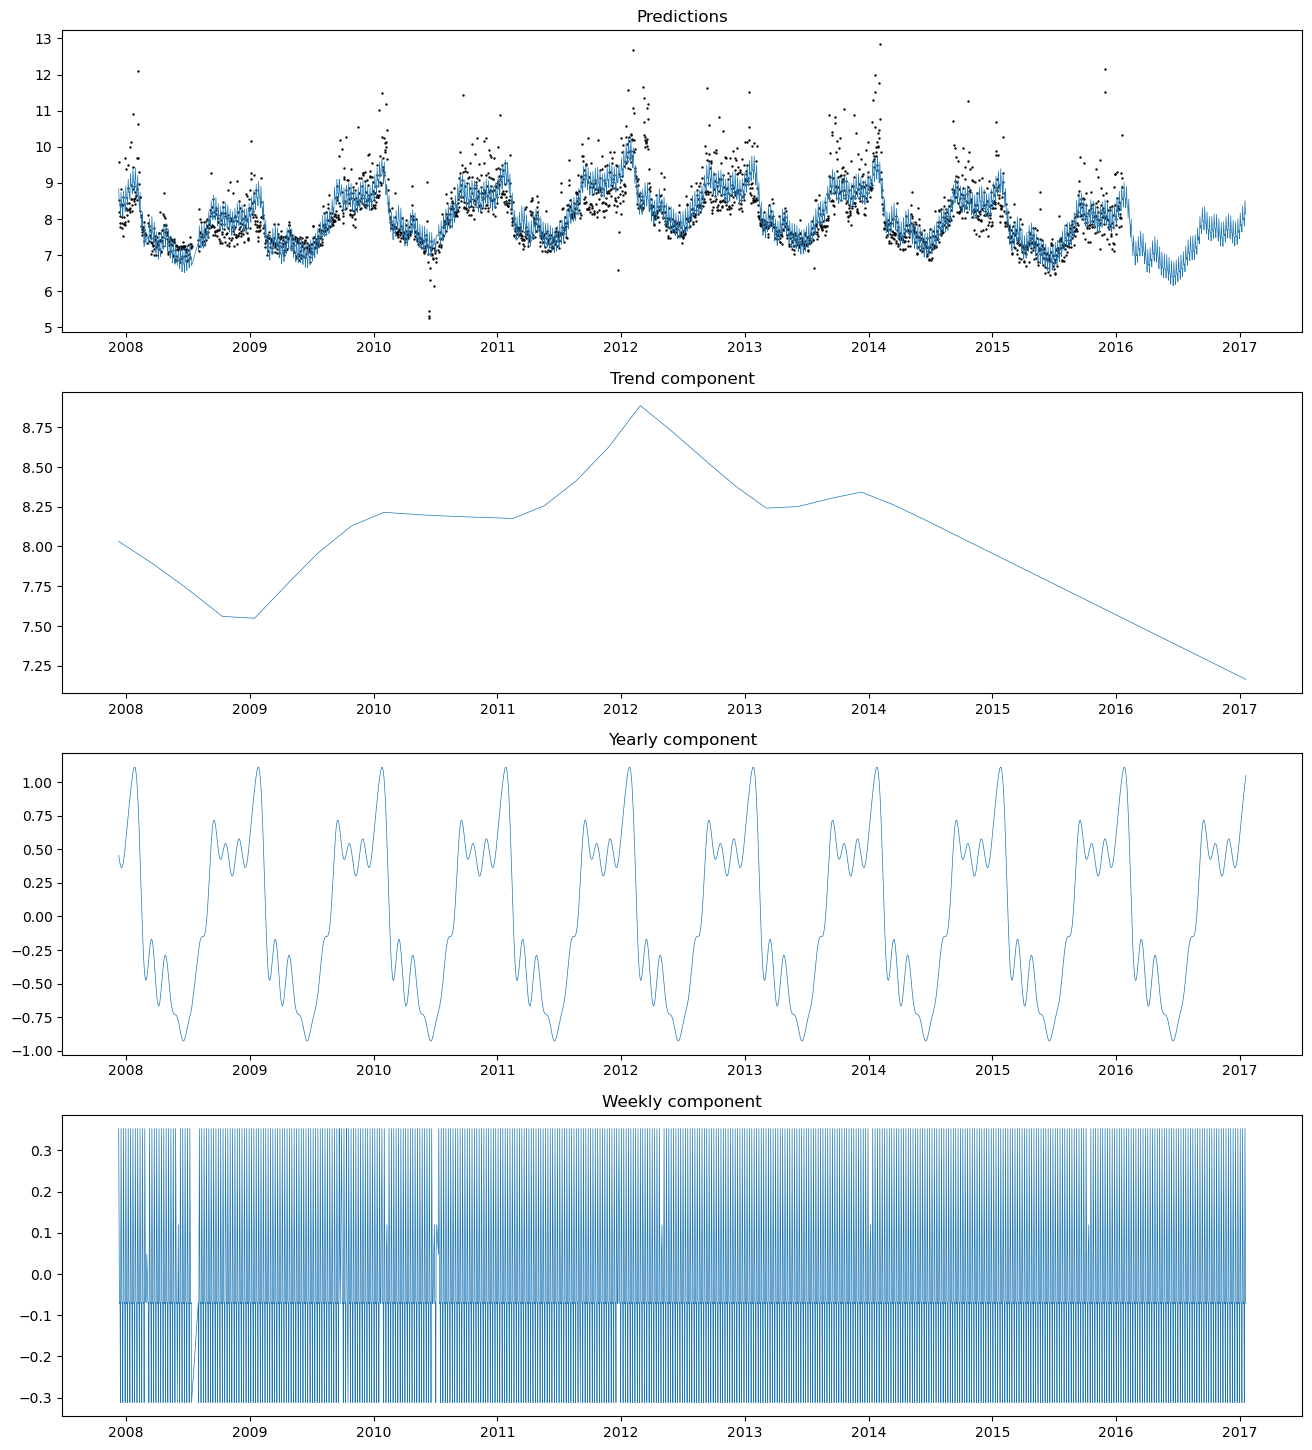

In [102]:
my_model = MyProphet(mcmc_samples=1000)
my_model.fit(df)
full_preds_mcmc = my_model._predict_mcmc(365, plot=True)

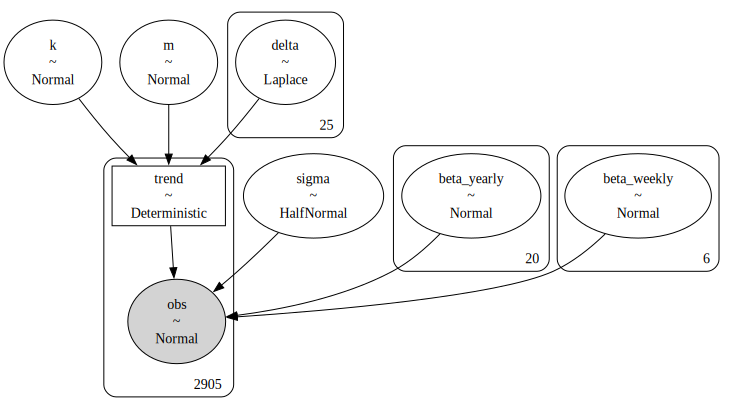

In [103]:
pm.model_to_graphviz(my_model.model)

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'm'}>, <Axes: title={'center': 'm'}>],
       [<Axes: title={'center': 'beta_yearly'}>,
        <Axes: title={'center': 'beta_yearly'}>],
       [<Axes: title={'center': 'beta_weekly'}>,
        <Axes: title={'center': 'beta_weekly'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'trend'}>,
        <Axes: title={'center': 'trend'}>]], dtype=object)

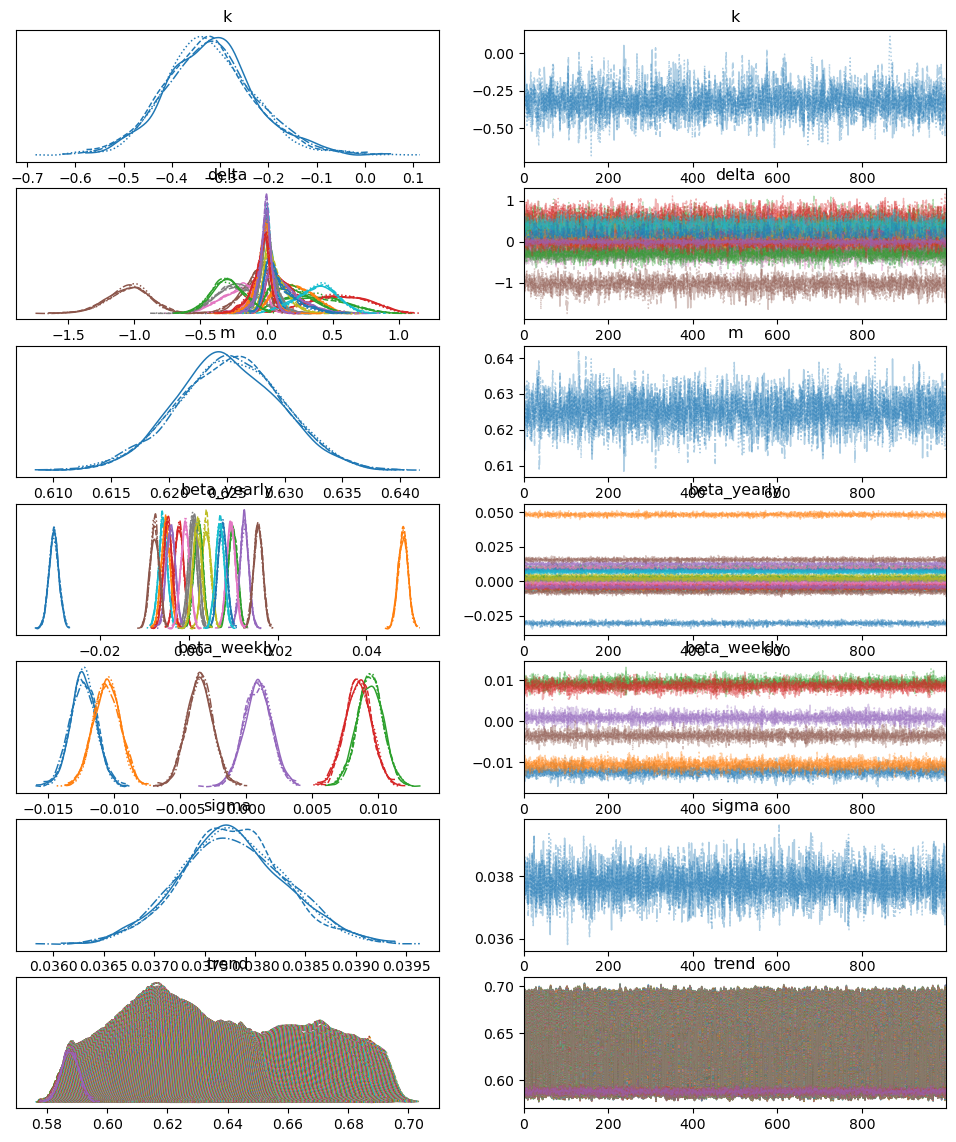

In [104]:
pm.plot_trace(my_model.trace)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

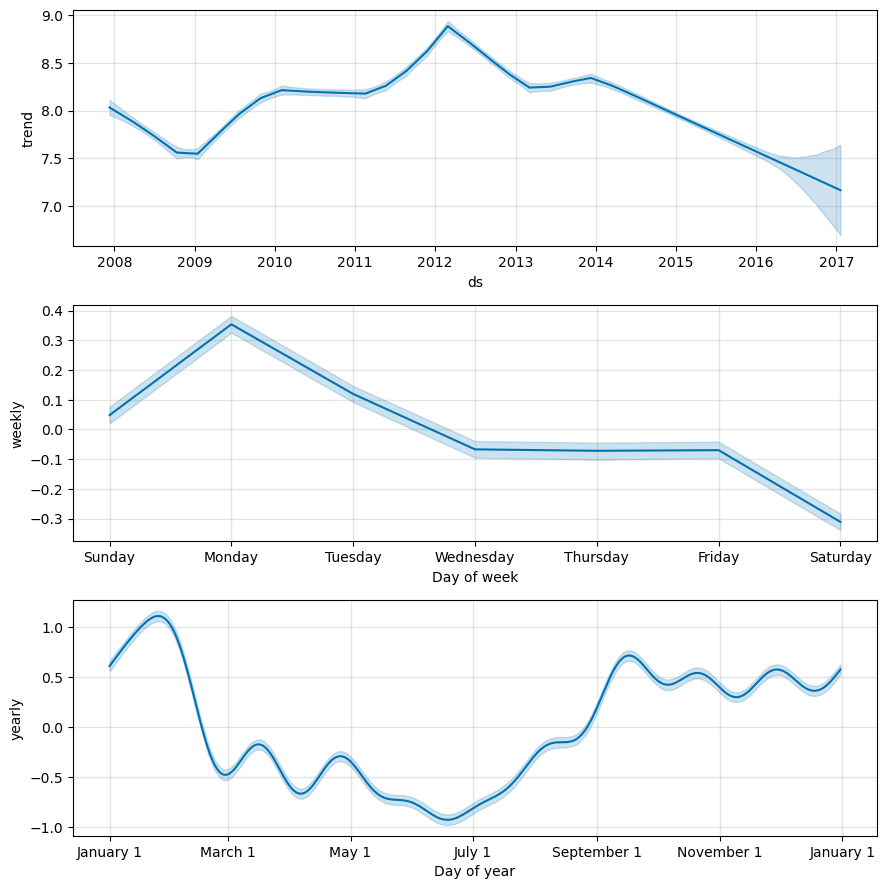

In [105]:
model = Prophet(mcmc_samples=1000)
model.fit(df)
future = model.make_future_dataframe(periods=365, include_history=True)
full_forecast = model.predict(future)
fig = model.plot_components(full_forecast)

In [106]:
mean_absolute_percentage_error(df["y"], full_forecast["yhat"][:len(df)])

0.03986990380864686

In [108]:
mean_absolute_percentage_error(df["y"], full_preds_mcmc["yhat"][:len(df)])

0.039873378452389585

In [109]:
mean_absolute_percentage_error(full_forecast["yhat"][:len(df)], full_preds_mcmc["yhat"][:len(df)])

0.00014434546222512868

# Test transfer from large window to small

In [6]:
large_window_train = df[:1500]
small_window_train = df[1500:2230]
full_window_train = df[:2230]
small_window_test = df[2230:2595]

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


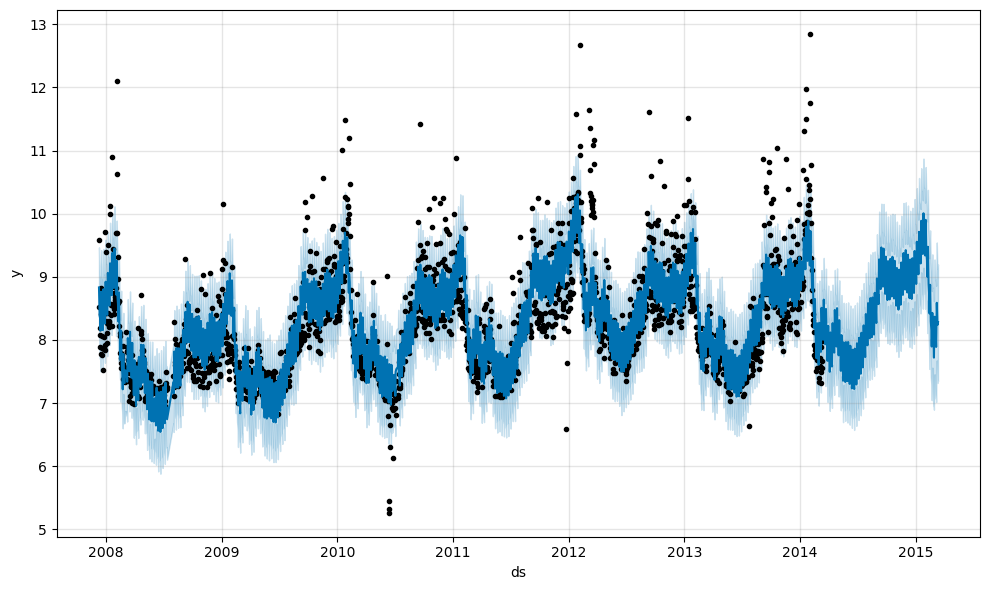

In [122]:
model = Prophet(mcmc_samples=1000)
model.fit(full_window_train)
future = model.make_future_dataframe(periods=365, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

In [7]:
large_model = MyProphet(mcmc_samples=1000)
large_model.fit(large_window_train)
# pm.plot_trace(large_model.trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 324 seconds.


In [13]:
summary = az.summary(large_model.trace, var_names=["k", "m", "delta", "beta_yearly", "beta_weekly"])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,-0.114,0.099,-0.298,0.074,0.002,0.001,2301.0,2198.0,1.0
m,0.631,0.006,0.620,0.641,0.000,0.000,2392.0,2806.0,1.0
delta[0],-0.021,0.072,-0.170,0.107,0.001,0.001,4764.0,2437.0,1.0
delta[1],-0.017,0.066,-0.156,0.103,0.001,0.001,4716.0,2172.0,1.0
delta[2],-0.040,0.073,-0.179,0.095,0.001,0.001,3436.0,1739.0,1.0
delta[3],-0.036,0.071,-0.176,0.082,0.001,0.001,3809.0,2148.0,1.0
delta[4],0.021,0.064,-0.088,0.160,0.001,0.001,4574.0,2315.0,1.0
delta[5],0.081,0.096,-0.075,0.263,0.002,0.001,3989.0,2767.0,1.0
delta[6],0.138,0.131,-0.060,0.385,0.002,0.002,3393.0,3030.0,1.0
delta[7],0.307,0.165,-0.005,0.583,0.003,0.002,3059.0,3550.0,1.0


In [9]:
beta_yearly_idx = [elem for elem in summary.index if elem.startswith("beta_yearly")]
beta_weekly_idx = [elem for elem in summary.index if elem.startswith("beta_weekly")]

k_mean = summary["mean"]["k"]
m_mean = summary["mean"]["m"]
beta_yearly_mean = summary["mean"][beta_yearly_idx]
beta_weekly_mean = summary["mean"][beta_weekly_idx]
yearly_prior_scale = summary["sd"][beta_yearly_idx]
weekly_prior_scale = summary["sd"][beta_weekly_idx]

In [10]:
small_model = MyProphet(
    mcmc_samples=1000, 
    beta_yearly_mean=beta_yearly_mean, 
    beta_weekly_mean=beta_weekly_mean, 
    # yearly_prior_scale=yearly_prior_scale,
    # weekly_prior_scale=weekly_prior_scale
)
small_model.fit(small_window_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 195 seconds.


In [ ]:
pm.plot_trace(small_model.trace)

Exception ignored in: <function _xla_gc_callback at 0x7ffb0e14be20>
Traceback (most recent call last):
  File "/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7ffb0e14be20>
Traceback (most recent call last):
  File "/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 
Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/ipykernel/iostream.py", line 609, in flush
  File "/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/threading.py", line 655, in wait
  File "/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/threading.py", line 359, in wait
    gotit

Error in callback <function _draw_all_if_interactive at 0x7ffb4c4bd300> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



/tmp/ipykernel_9745/1539134068.py:193: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


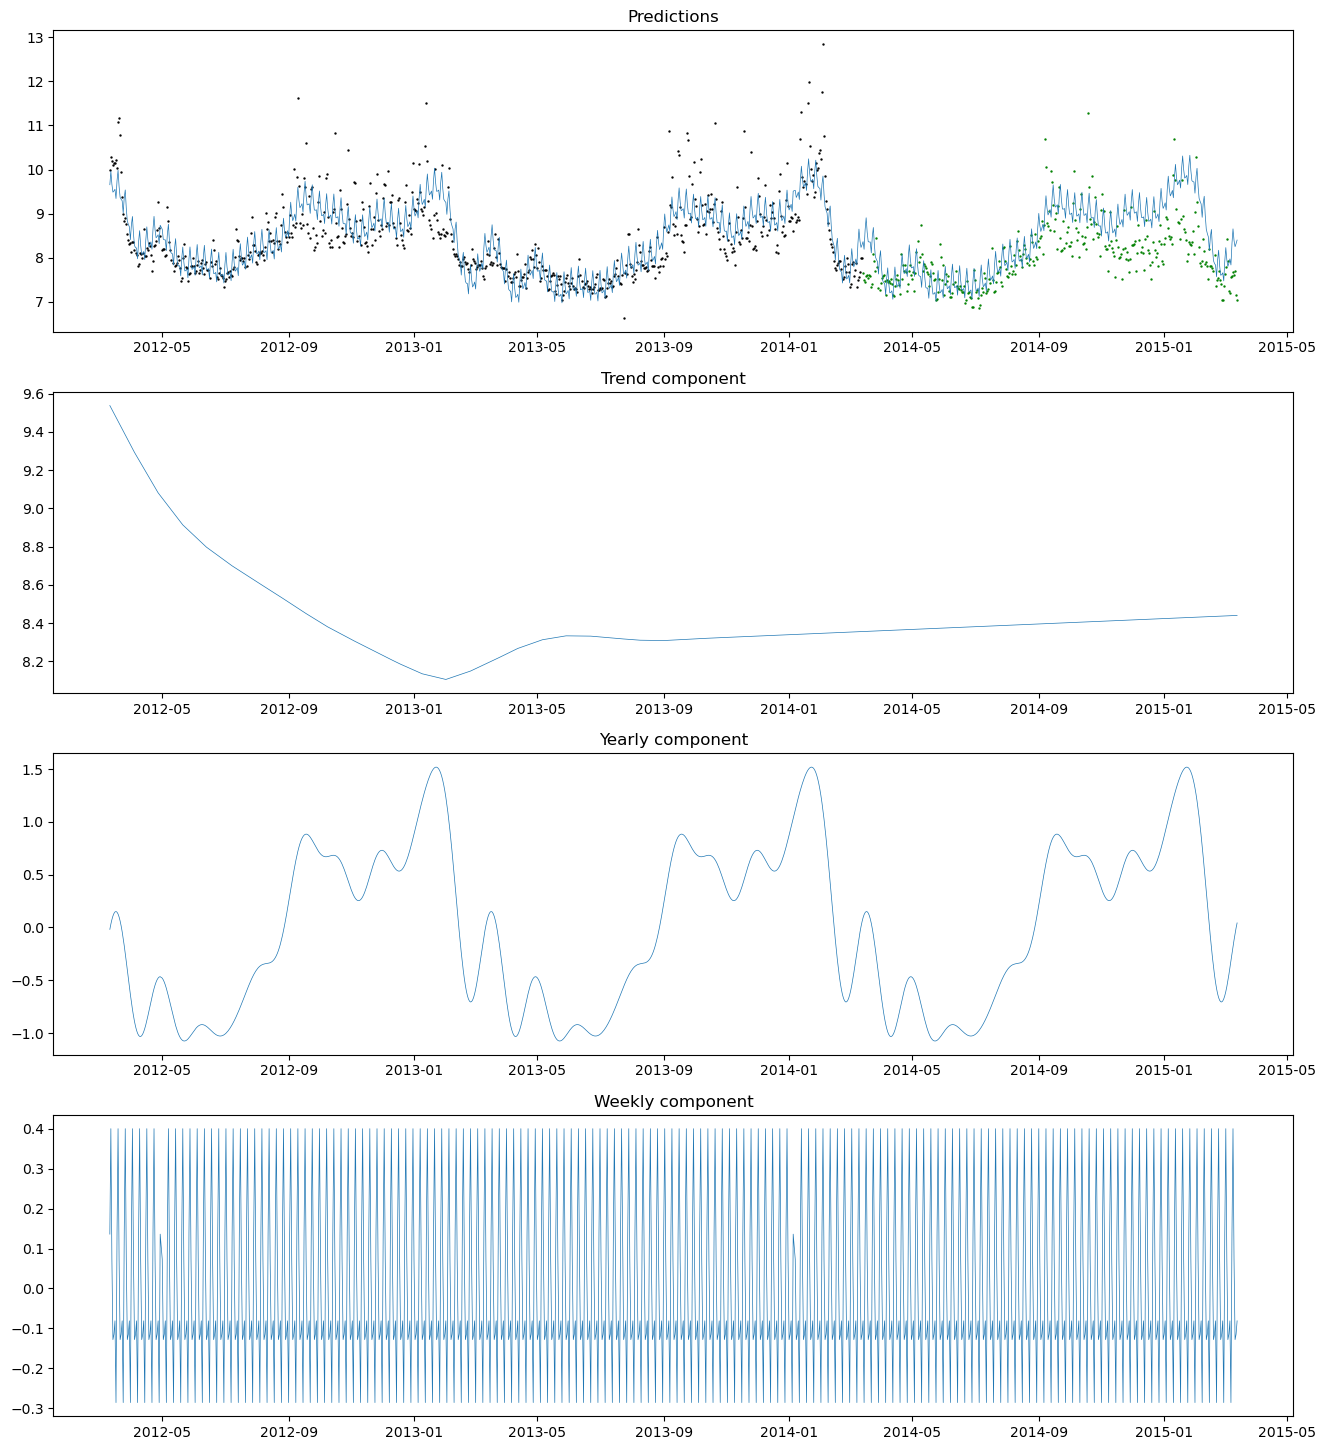

In [11]:
preds = small_model._predict_mcmc(365, y_true=small_window_test["y"], plot=True)

In [147]:
mean_absolute_percentage_error(small_window_test["y"], forecast["yhat"][len(full_window_train):])

0.06899559203397886

In [12]:
mean_absolute_percentage_error(small_window_test["y"], preds["yhat"][len(small_window_train):])

0.0652855069983091

In [141]:
small_model_default = MyProphet(mcmc_samples=1000)
small_model_default.fit(small_window_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 184 seconds.


/tmp/ipykernel_1009/2987390984.py:187: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


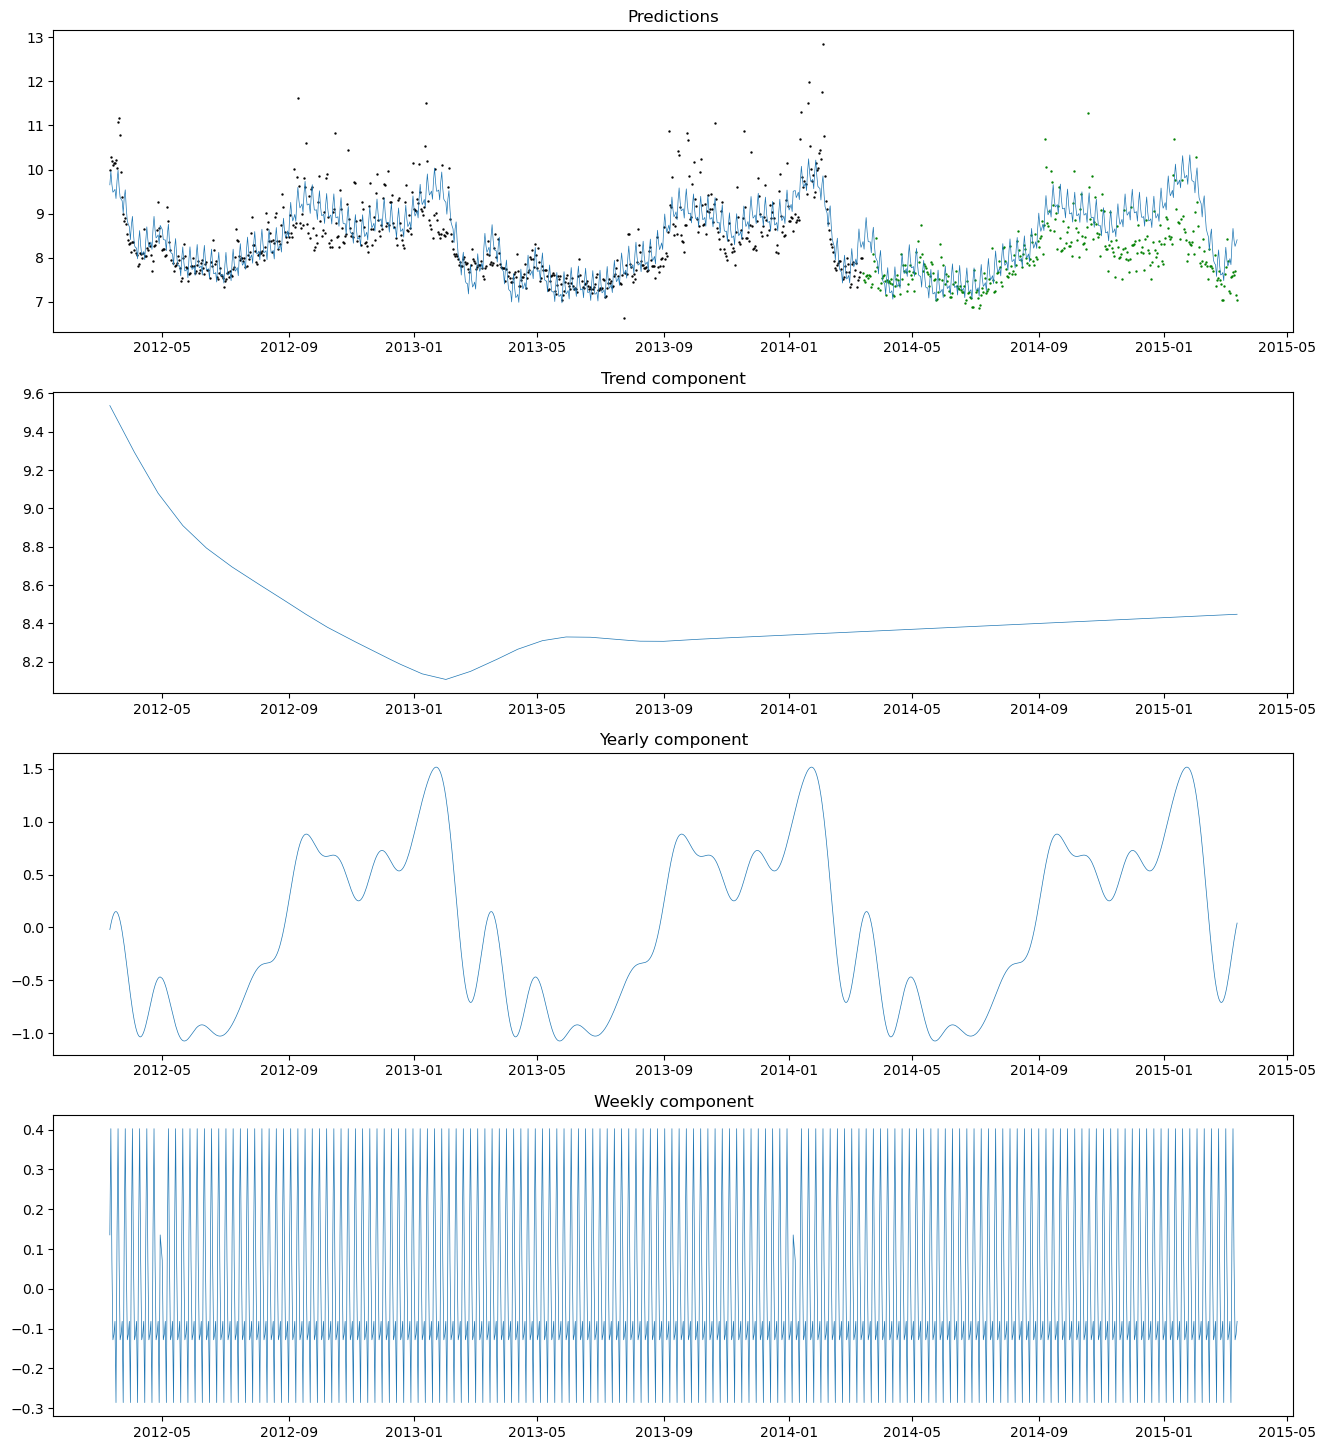

In [142]:
default_preds = small_model_default._predict_mcmc(365, y_true=small_window_test["y"], plot=True)

In [143]:
mean_absolute_percentage_error(small_window_test["y"], default_preds["yhat"][len(small_window_train):])

0.06565825215333314

# Test strategies

In [18]:
model_wrapper = MyProphetWrapper()
prophet_preds = model_wrapper.test_prophet(df, extend_window=False)
prophet_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:05<00:00,  1.00s/it]


,horizon,mse,rmse,mae,mape
0,1,0.310349,0.557090,0.409990,0.048283
1,2,0.329031,0.573613,0.423143,0.049836
2,3,0.343626,0.586196,0.432513,0.051037
3,4,0.358261,0.598549,0.442182,0.052173
4,5,0.368531,0.607067,0.448885,0.052973
...,...,...,...,...,...
360,361,2.355649,1.534812,1.146263,0.140264
361,362,2.364379,1.537654,1.147494,0.140490
362,363,2.370242,1.539559,1.147800,0.140673
363,364,2.397023,1.548232,1.153333,0.141468


In [19]:
my_preds = model_wrapper.test_my_prophet(df, extend_window=False, update_priors_days=0)
my_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:03<00:00,  1.01it/s]


,horizon,mse,rmse,mae,mape
0,1,0.311117,0.557778,0.410461,0.048351
1,2,0.330992,0.575319,0.424657,0.050032
2,3,0.345589,0.587868,0.433522,0.051167
3,4,0.359666,0.599721,0.443441,0.052350
4,5,0.370216,0.608454,0.450172,0.053156
...,...,...,...,...,...
360,361,2.386416,1.544803,1.160611,0.142009
361,362,2.396719,1.548134,1.160567,0.142025
362,363,2.402509,1.550003,1.160376,0.142143
363,364,2.428646,1.558411,1.165420,0.142867


In [20]:
prophet_extended_preds = model_wrapper.test_prophet(df, extend_window=True)
prophet_extended_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:04<00:00,  1.00it/s]


,horizon,mse,rmse,mae,mape
0,1,0.307345,0.554387,0.401853,0.046985
1,2,0.315383,0.561590,0.407574,0.047648
2,3,0.322017,0.567465,0.412079,0.048247
3,4,0.331447,0.575714,0.417853,0.048912
4,5,0.336436,0.580031,0.420993,0.049277
...,...,...,...,...,...
360,361,1.100175,1.048892,0.835052,0.102521
361,362,1.100399,1.048999,0.834881,0.102538
362,363,1.095564,1.046692,0.833512,0.102474
363,364,1.099178,1.048417,0.836139,0.102849


In [21]:
my_extended_preds = model_wrapper.test_my_prophet(df, extend_window=True, update_priors_days=0)
my_extended_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:09<00:00,  1.01s/it]


,horizon,mse,rmse,mae,mape
0,1,0.316623,0.562693,0.405323,0.047441
1,2,0.325765,0.570758,0.411156,0.048130
2,3,0.328679,0.573306,0.415676,0.048711
3,4,0.336904,0.580434,0.421440,0.049371
4,5,0.339833,0.582952,0.423619,0.049615
...,...,...,...,...,...
360,361,1.094196,1.046038,0.829831,0.101927
361,362,1.096444,1.047112,0.831065,0.102099
362,363,1.093882,1.045888,0.831170,0.102192
363,364,1.096613,1.047193,0.835093,0.102705


In [23]:
update_priors_preds = model_wrapper.test_my_prophet(df, extend_window=False, update_priors_days=1)
update_priors_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:09<00:00,  1.01s/it]


,horizon,mse,rmse,mae,mape
0,1,0.310956,0.557634,0.410010,0.048290
1,2,0.329919,0.574386,0.423784,0.049919
2,3,0.344170,0.586660,0.432678,0.051068
3,4,0.359539,0.599616,0.442799,0.052264
4,5,0.369936,0.608224,0.449786,0.053097
...,...,...,...,...,...
360,361,2.364895,1.537822,1.156453,0.141497
361,362,2.369352,1.539270,1.156272,0.141526
362,363,2.375226,1.541177,1.154821,0.141489
363,364,2.402464,1.549988,1.159336,0.142134


In [37]:
model_wrapper = MyProphetWrapper()
update_all_priors_preds = model_wrapper.test_my_prophet(df, extend_window=False, update_priors_days=1)
update_all_priors_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:09<00:00,  1.01s/it]


,horizon,mse,rmse,mae,mape
0,1,0.310128,0.556891,0.409327,0.048189
1,2,0.328729,0.573349,0.422602,0.049761
2,3,0.343312,0.585928,0.432131,0.050981
3,4,0.358548,0.598789,0.442131,0.052157
4,5,0.369398,0.607781,0.449422,0.053020
...,...,...,...,...,...
360,361,2.396909,1.548195,1.164687,0.142562
361,362,2.410857,1.552693,1.166231,0.142747
362,363,2.414861,1.553982,1.165121,0.142770
363,364,2.439490,1.561887,1.170250,0.143506


In [15]:
model_wrapper = MyProphetWrapper(mcmc_samples=1000)
prior_from_idata_preds = model_wrapper.test_my_prophet(df, extend_window=False, update_priors_days=30, limit=100)
prior_from_idata_preds

  0%|                                                                         | 0/100 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 193 seconds.
 30%|███████████████████▏                                            | 30/100 [04:21<01:48,  1.55s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 153 seconds.
 60%|██████████████████████████████████████▍                         | 60/100 [07:55<00:54,  1.35s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 141 seconds.
 90%|█████████████████████████████████████████████████████████▌      | 90/100 [11:16<00:13,  1.38s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 201 seconds.
100%|███████████████████████████████████████████████████████████████| 365/365 [00:23<00:00, 15.86it/s]


,horizon,mse,rmse,mae,mape
0,1,0.350701,0.592200,0.446557,0.052375
1,2,0.334292,0.578180,0.447064,0.053349
2,3,0.334261,0.578153,0.444944,0.053711
3,4,0.379897,0.616358,0.477855,0.057237
4,5,0.413308,0.642890,0.497428,0.059497
...,...,...,...,...,...
360,361,1.986927,1.409584,1.235836,0.153563
361,362,1.978936,1.406747,1.232364,0.153246
362,363,1.970554,1.403764,1.228668,0.152995
363,364,1.980072,1.407150,1.228950,0.153730


In [17]:
prior_from_idata_preds["mape"].mean()

0.09954582348038958

In [19]:
model_wrapper = MyProphetWrapper()
my_normal_preds = model_wrapper.test_my_prophet(df, extend_window=False, update_priors_days=0, limit=100)
my_normal_preds

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [00:23<00:00, 15.61it/s]


,horizon,mse,rmse,mae,mape
0,1,0.313655,0.560049,0.432409,0.051011
1,2,0.294844,0.542995,0.432247,0.051885
2,3,0.279416,0.528598,0.427891,0.052016
3,4,0.326604,0.571493,0.459061,0.055306
4,5,0.346881,0.588966,0.478249,0.057576
...,...,...,...,...,...
360,361,2.005233,1.416062,1.243355,0.154392
361,362,1.999651,1.414090,1.241631,0.154293
362,363,2.004557,1.415824,1.242591,0.154692
363,364,2.033915,1.426154,1.247291,0.155968


In [18]:
model_wrapper = MyProphetWrapper()
prophet_preds = model_wrapper.test_prophet(df, extend_window=False, limit=100, window=730)
prophet_preds

100%|███████████████████████████████████████████████████████████████| 365/365 [00:22<00:00, 16.19it/s]


,horizon,mse,rmse,mae,mape
0,1,0.312073,0.558635,0.430950,0.050849
1,2,0.293021,0.541315,0.430602,0.051694
2,3,0.276024,0.525380,0.426696,0.051880
3,4,0.326116,0.571065,0.458342,0.055210
4,5,0.344384,0.586843,0.478165,0.057574
...,...,...,...,...,...
360,361,1.961327,1.400474,1.236377,0.153569
361,362,1.956249,1.398660,1.232953,0.153260
362,363,1.955823,1.398507,1.229071,0.153027
363,364,1.982924,1.408163,1.237602,0.154813


In [30]:
prior_from_idata_preds["mape"].mean(), my_normal_preds["mape"].mean(), prophet_preds["mape"].mean()

(0.10067149690049439, 0.09901501040949295, 0.09817343988522548)

In [38]:
model_wrapper = MyProphetWrapper()
update_all_priors_preds_extended = model_wrapper.test_my_prophet(df, extend_window=True, update_priors_days=1)
update_all_priors_preds_extended

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [06:13<00:00,  1.02s/it]


,horizon,mse,rmse,mae,mape
0,1,0.307843,0.554836,0.402200,0.047037
1,2,0.315725,0.561894,0.408250,0.047744
2,3,0.322446,0.567843,0.412585,0.048323
3,4,0.331633,0.575876,0.418321,0.048982
4,5,0.336898,0.580429,0.421130,0.049304
...,...,...,...,...,...
360,361,1.096108,1.046952,0.832419,0.102220
361,362,1.095029,1.046437,0.831237,0.102124
362,363,1.090654,1.044344,0.831719,0.102275
363,364,1.095306,1.046568,0.833919,0.102598


In [83]:
model = MyProphet(mcmc_samples=1000)
model.fit(df[start:start + window])
# mcmc_preds = model._predict_mcmc(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [k, delta, m, beta_yearly, beta_weekly, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 267 seconds.


In [99]:
idx = [elem for elem in az.summary(model.trace, var_names=["delta", "beta_weekly"], round_to=10).index if elem.startswith("delta")]

In [106]:
az.summary(model.trace, var_names=["delta", "beta_weekly"], round_to=10)["sd"][idx].max()

0.1426130894

In [84]:
next_model = MyProphet(mcmc_samples=1000, old_trace=model.trace)
next_model.fit(df[start:start + window])
# next_mcmc_preds = next_model._predict_mcmc(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [trace_prior_, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


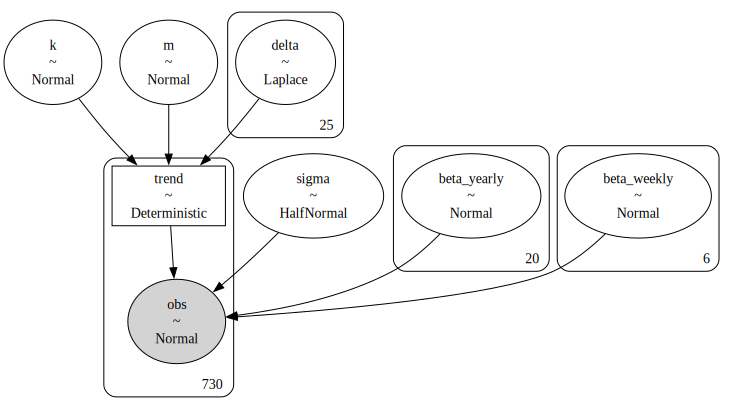

In [85]:
pm.model_to_graphviz(model.model)

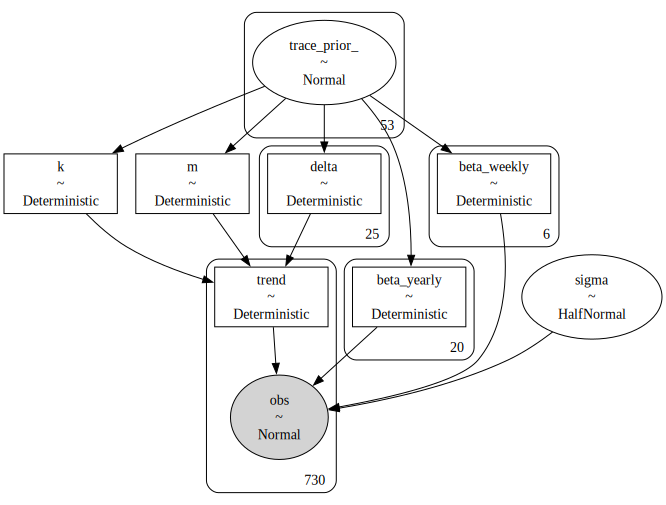

In [86]:
pm.model_to_graphviz(next_model.model)

In [61]:
with pm.Model() as tmp_model:
    priors = pmx.utils.prior.prior_from_idata(
        model.trace, 
        var_names=["k", "m", "delta", "beta_yearly", "beta_weekly"]
    )
    trace1 = pm.sample_prior_predictive(1000)

Sampling: [trace_prior_]


In [62]:
trace1["prior"]["k"].mean(), trace1["prior"]["k"].std()

(<xarray.DataArray 'k' ()> Size: 8B
 array(0.08447162),
 <xarray.DataArray 'k' ()> Size: 8B
 array(0.00773474))

In [63]:
trace1["prior"]["m"].mean(), trace1["prior"]["m"].std()

(<xarray.DataArray 'm' ()> Size: 8B
 array(0.63627912),
 <xarray.DataArray 'm' ()> Size: 8B
 array(0.00367261))